In [1]:
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.utils import print_dict

from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

F:\Users\Raven\AppData\Local\Continuum\anaconda3\envs\tf20\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# rcParams['figure.figsize'] = (50,10)

In [3]:
ukdale = DataSet('./dataset/ukdale.h5')

In [4]:
print_dict(ukdale.buildings[5].metadata)

In [5]:
ukdale.set_window(start = "2014-07-07", end = "2014-07-14")

elec = ukdale.buildings[5].elec
elec

MeterGroup(meters=
  ElecMeter(instance=2, building=5, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])
  ElecMeter(instance=3, building=5, dataset='UK-DALE', appliances=[Appliance(type='desktop computer', instance=1)])
  ElecMeter(instance=4, building=5, dataset='UK-DALE', appliances=[Appliance(type='hair dryer', instance=1)])
  ElecMeter(instance=5, building=5, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=6, building=5, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])
  ElecMeter(instance=7, building=5, dataset='UK-DALE', appliances=[Appliance(type='running machine', instance=1)])
  ElecMeter(instance=8, building=5, dataset='UK-DALE', appliances=[Appliance(type='network attached storage', instance=1)])
  ElecMeter(instance=9, building=5, dataset='UK-DALE', appliances=[Appliance(type='server computer', instance=1)])
  ElecMeter(instance=10, building=5, dataset='UK-DALE', appli

In [6]:
fridge = elec['fridge freezer']
fridge.available_columns()
fridge_df = next(fridge.load())

In [7]:
data = fridge_df
data

physical_quantity,power
type,active
2014-07-07 00:00:03+01:00,110.0
2014-07-07 00:00:09+01:00,109.0
2014-07-07 00:00:15+01:00,110.0
2014-07-07 00:00:21+01:00,112.0
2014-07-07 00:00:27+01:00,112.0
2014-07-07 00:00:33+01:00,110.0
2014-07-07 00:00:39+01:00,109.0
2014-07-07 00:00:45+01:00,111.0
2014-07-07 00:00:51+01:00,112.0


In [8]:
data.shape, len(data)

((98071, 1), 98071)

In [9]:
seq_length = 3*60*10
delay = 60*5

In [10]:
data_ = []
for i in range(len(data)- seq_length - delay):
    data_.append(data.iloc[i : i+seq_length +delay])

In [11]:
data_[0].shape

(2100, 1)

In [12]:
data_ = np.array([df.values for df in data_])

In [13]:
data_.shape

(95971, 2100, 1)

In [14]:
np.random.shuffle(data_)

In [15]:
x = data_[:, :3*60*10, :]
y = data_[:,-1, 0]
x.shape, y.shape

((95971, 1800, 1), (95971,))

In [16]:
split_b = int(data_.shape[0]*0.8)

In [17]:
train_x = x[ :split_b]
train_y = y[ :split_b]
test_x = x[split_b: ]
test_y = y[split_b: ]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((76776, 1800, 1), (76776,), (19195, 1800, 1), (19195,))

In [18]:
# mean = train_x.mean(axis = 0)
# std = train_x.std(axis = 0)

In [19]:
# train_x = (train_x - mean)/std
# test_x = (test_x - mean)/std

### LSTM

In [20]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1800, 32)          4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',
             loss = 'mse',
             metrics = ['mae'])

In [23]:
history = model.fit(train_x, train_y,
                   batch_size = 512,
                   epochs = 100,
                   validation_data = (test_x, test_y))

Train on 76776 samples, validate on 19195 samples
Epoch 1/100
76776/76776 [==============================] - 55s 721us/sample - loss: 3970.4341 - mae: 41.4752 - val_loss: 3691.3344 - val_mae: 42.4435
Epoch 2/100
76776/76776 [==============================] - 47s 614us/sample - loss: 3547.2344 - mae: 42.2786 - val_loss: 3402.7614 - val_mae: 41.9610
Epoch 3/100
76776/76776 [==============================] - 47s 607us/sample - loss: 3278.6746 - mae: 41.2266 - val_loss: 3155.1864 - val_mae: 40.7304
Epoch 4/100
76776/76776 [==============================] - 46s 605us/sample - loss: 3052.2031 - mae: 40.5902 - val_loss: 2949.4775 - val_mae: 40.2028
Epoch 5/100
76776/76776 [==============================] - 47s 608us/sample - loss: 2859.1258 - mae: 39.9647 - val_loss: 2770.1509 - val_mae: 39.7500
Epoch 6/100
76776/76776 [==============================] - 47s 609us/sample - loss: 2694.9079 - mae: 39.4262 - val_loss: 2621.5916 - val_mae: 39.1548
Epoch 7/100
76776/76776 [=========================

Epoch 55/100
76776/76776 [==============================] - 50s 646us/sample - loss: 1885.5560 - mae: 32.8494 - val_loss: 1891.9444 - val_mae: 32.8753
Epoch 56/100
76776/76776 [==============================] - 48s 626us/sample - loss: 1883.1361 - mae: 32.8338 - val_loss: 1886.8006 - val_mae: 32.5318
Epoch 57/100
76776/76776 [==============================] - 48s 624us/sample - loss: 1881.6563 - mae: 32.7171 - val_loss: 1904.8162 - val_mae: 32.6264
Epoch 58/100
76776/76776 [==============================] - 48s 620us/sample - loss: 1884.3548 - mae: 32.7829 - val_loss: 1889.7127 - val_mae: 32.9199
Epoch 59/100
76776/76776 [==============================] - 48s 622us/sample - loss: 1879.2474 - mae: 32.7065 - val_loss: 1882.6364 - val_mae: 33.2909
Epoch 60/100
76776/76776 [==============================] - 48s 624us/sample - loss: 1865.2242 - mae: 32.6729 - val_loss: 1771.7028 - val_mae: 31.8243
Epoch 61/100
76776/76776 [==============================] - 48s 629us/sample - loss: 1797.1093

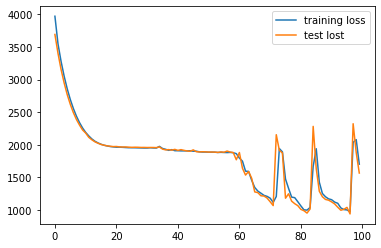

In [24]:
plt.plot(history.epoch, history.history.get('loss'), label = "training loss")
plt.plot(history.epoch, history.history.get('val_loss'), label = 'test lost')
plt.legend()